In [1]:
%matplotlib inline


# Inverse Gaussian Regression


We would like to use an example to show how the sparse-constrained optimization for inverse gaussian regression works in our program.

## Inverse Gaussian Regression or wald regression
The inverse Gaussian distribution is a continuous probability distribution with probability density function:
$$
f(y|\mu,\lambda) = \sqrt{\frac{\lambda}{2\pi y^3}}\exp\left(-\frac{\lambda(y-\mu)^2}{2\mu^2y}\right)
$$
where $y>0$, mean $\mu>0$, and dispersion parameter $\lambda>0$. In fact, the inverse Gaussian distribution can also use the variance $\sigma^{2}$ to represent the shape parameter, and the relationship between the two is $\lambda = 1/\sigma^{2}$. We then use $\sigma^{2}$ to reparameterize the probability density function of the inverse Gaussian distribution:
$$
f\left(y ; \mu, \sigma^2\right)=\frac{1}{\sqrt{2 \pi y^3 \sigma^2}} \exp \left\{-\frac{(y-\mu)^2}{2(\mu \sigma)^2 y}\right\}
$$

In inverse Gaussian regression, we assume that the response variable $yi$ follows an inverse Gaussian distribution with mean $\mu_i$ and variance parameter $\sigma^{2}$. In GLM, we model the mean $\mu_i$ as $\frac{1}{2 \mu_i^2}=x_i^T\beta$.

where $\beta$ is a vector of unknown regression coefficients, and $x_i$ is a vector of predictor variables for the $i$th observation.

With $n$ independent data of the explanatory variables $x$ and the response variable $y$, we can estimate $\beta$ by minimizing the negative log-likelihood function under sparsity constraint:

<a id='loss'></a>
$$
\arg \min _{\beta \in R^p} L(\beta):=-\frac{1}{n} \sum_{i=1}^n \left\{\frac{y_i x_i^T\beta-\sqrt{2 x_i^T\beta}}{-\sigma^2}-\frac{1}{2 y_i \sigma^2}-\frac{1}{2} \ln \left(2 \pi y_i^3 \sigma^2\right)\right\}, \text { s.t. }\|\beta\|_0 \leq s .\tag{1}
$$

Here is Python code for solving sparse Inverse Gaussian Regression problem:

### Import necessary packages 

In [4]:
import jax.numpy as jnp
import numpy as np
from scope import ScopeSolver
import numpy as np

### Set a seed

In [5]:
np.random.seed(123)

### Generate the data

Firstly, we define a data generator function to provide a way to generate suitable dataset for this task.

The model: 
* $y \sim \text{invgaussian}(\mu, \lambda), \mu = 1/\sqrt(2*(x^T \beta + \epsilon)), \beta \sim U[1, 2], \lambda\sim U[0.1, 100.1]$ in shape-scale definition.



In [6]:
def sample(p, k):
    full = np.arange(p)
    select = sorted(np.random.choice(full, k, replace=False))
    return select

def make_inverse_gaussian_regression_data(n, p, k, rho=0, corr_type="const", random_state=None):
    np.random.seed(random_state)
    if corr_type == "exp":
        # generate correlation matrix with exponential decay
        R = np.zeros((p, p))
        for i in range(p):
            for j in range(i, p):
                R[i, j] = rho ** abs(i - j)
        R = R + R.T - np.identity(p)
    elif corr_type == "const":
        # generate correlation matrix with constant correlation
        R = np.ones((p, p)) * rho
        for i in range(p):
            R[i, i] = 1
    else:
        raise ValueError(
            "corr_type should be \'const\' or \'exp\'")

    x = np.random.multivariate_normal(mean=np.zeros(p), cov=R, size=(n,))
    
    nonzero = sample(p, k)
    Tbeta = np.zeros(p)
    sign = np.random.choice([1, -1], k)

    Tbeta[nonzero] = np.random.uniform(1, 2, k) * sign
    # add noise
    eta = x @ Tbeta + np.random.normal(0, 1, n)
    # set coef_0 to make eta>0
    eta = eta + np.abs(np.min(eta)) + 1
    mu = np.sqrt(1 / (2 * eta))
    # set the shape para of gamma uniformly in [0.1,100.1]
    shape_para = 100 * np.random.uniform(0, 1, 1) + 0.1
    
    y = np.random.wald(
        mean=mu,
        scale=shape_para,
        size=n)
    
    return x, y, Tbeta


We then use this function to generate a data set containg 500 observations and set only 5 of the 500 variables to have effect on the expectation of the response. 

In [7]:
n = 500
p = 500
s = 5
x, y, coef_ = make_inverse_gaussian_regression_data(n=n, p=p, k=s)

print("The predictor variables of the first five samples:",'\n',x[:,:5])
print("The first five noisy observations:", '\n', y[:5])

The predictor variables of the first five samples: 
 [[ 0.85333806  0.42035179 -0.83650549 -1.05078447  1.64257997]
 [-0.0090094   0.87067429 -1.51995846 -0.26814789 -1.15950071]
 [ 0.14740578  0.86978549  0.68969919  0.72877506 -0.01683556]
 ...
 [ 0.62295509  0.45955982 -0.23186249 -1.61251813  0.15725694]
 [-0.83419535  0.33978008  0.28627336 -1.27024831  1.78917345]
 [-1.49402514  1.0668483   1.29668663  1.37658076  0.78598676]]
The first five noisy observations: 
 [0.0965436  0.53446712 0.09841531 0.23741934 0.26822657]


We augment data to avoid errors in the following codes:

In [8]:
X = np.hstack((np.ones((n, 1)), x))
true_params = np.hstack(([0.0], coef_))

### Define inverse gaussian regression loss

Secondly, we define the loss function `inverse_gaussian_regression_loss` accorting to [1](#loss) that matches the data generating function `make_inverse_gaussian_regression_data`.

In [10]:
def inverse_gaussian_regression_loss(params):
    xbeta = jnp.clip(X @ params, -30, 30)
    return jnp.mean(jnp.sqrt(2*xbeta) - y * xbeta)

We note that when computing the gamma loss, $x_i^T \beta$ may less than 0 and give `np.nan` or raise error, we should change the initial value of the parameters to make sure that $x_i^T \beta$ > 0, the following code give an example to deal with this problem.

In [11]:
def convex_solver_inverse_gaussian(
    loss_fn,
    value_and_grad,
    params,
    optim_variable_set,
    data,
):
    """
    change the initial value of the parameters to let X @ params > 0
    """
    m = np.min(X @ params)
    if m <= 0.0:
        params[0] -= m
    return convex_solver_nlopt(loss_fn, value_and_grad, params, optim_variable_set, data)

### Use scope to solve the sparse inverse gaussian regression problem

After defining the data generation and loss function, we can call `ScopeSolver` to solve the sparse-constrained optimization problem.


In [ ]:
solver = ScopeSolver(p+1, s+1, always_select=[0], numeric_solver=convex_solver_inverse_gaussian)
params = solver.solve(inverse_gaussian_regression_loss, init_params=np.hstack(([1.0], np.zeros(p))), jit=True)

Now the `solver.params` contains the coefficients of gamma model with no more than 5 variables. That is, those variables with a coefficient 0 is unused in the model:

In [ ]:
print(solver.params)

We can further compare the coefficients estimated by `scope` and the real coefficients in two-fold:

* The true support set and the estimated support set

* The true nonzero parameters and the estimated nonzero parameters


In [ ]:
true_support_set =  np.nonzero(true_params)[0]
estimated_support_set =  (solver.support_set)[1:]

print("True support set: ", true_support_set)
print("Estimated support set: ", estimated_support_set)

In [ ]:
print("True parameters: ", true_params[true_support_set])
print("Estimated parameters: ", solver.params[estimated_support_set])

### More on the results

We can plot the sparse signal recovering from the noisy observations to visualize the results.

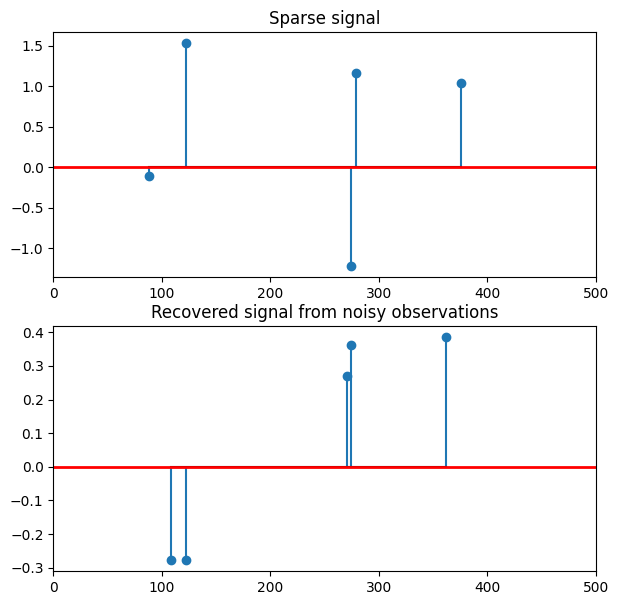

In [10]:
import matplotlib.pyplot as plt

# plot the sparse signal
plt.figure(figsize=(7, 7))
plt.subplot(2, 1, 1)
plt.stem(true_support_set, true_params[true_support_set], markerfmt='o', basefmt='k-')
plt.plot([0, 500], [0, 0], 'r-', lw=2)
plt.xlim(0, 500)
plt.title("Sparse signal")
#plt.plot(inx_true, true_params[inx_true], drawstyle='steps-post')

# plot the noisy reconstruction
plt.subplot(2, 1, 2)
plt.stem(estimated_support_set, solver.params[estimated_support_set], markerfmt='o', basefmt='k-')
plt.plot([0, 500], [0, 0], 'r-', lw=2)
plt.xlim(0, 500)
plt.title("Recovered signal from noisy observations")
#plt.plot(inx_est, solver.params[inx_est], drawstyle='steps-post')

plt.show()

### References

<div id="refer-1"></div>

- [1] Wikipedia, "Inverse Gaussian distribution".
https://en.wikipedia.org/wiki/Inverse_Gaussian_distribution

<div id="refer-2"></div>

- [2] Numpy, "np.random.wald".
https://numpy.org/doc/stable/reference/random/generated/numpy.random.wald.html#numpy.random.wald
